In [1]:
# env set up
import os
import torch
os.environ['KMP_DUPLICATE_LIB_OK']='True'
torch.backends.cudnn.benchmark=True #accerelate GPU Speed

#pytorch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import models as m
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from time import time
import datetime
import random
import numpy as np
import pandas as pd
import gc #garbage collector

#set global seed
torch.manual_seed(1412) #torch
random.seed(1412) #random
np.random.seed(1412) #numpy.random

#GPU-True，CPU-False
torch.cuda.is_available()
#True

#GPU-device = "gpu", cpu-device = "cpu"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
#device(type='cuda')

device(type='cpu')

torch.Size([3, 32, 32])
1


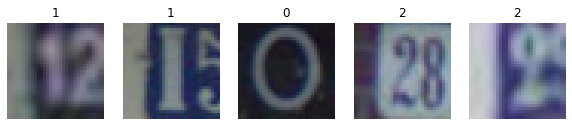

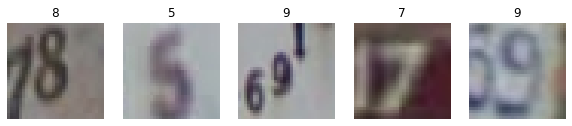

In [2]:
#import data
train = torchvision.datasets.SVHN(root ="./"
                                 ,split ="train"
                                 ,download = False
                                 ,transform = T.ToTensor()
                                 )
test = torchvision.datasets.SVHN(root ="./"
                                 ,split ="test"
                                 ,download = False
                                 ,transform = T.ToTensor())
train
#Dataset SVHN
#    Number of datapoints: 73257
#    Root location: /Users/zhucan/Desktop/SVHN
#    Split: train
#    StandardTransform
#Transform: ToTensor()
test
#Dataset SVHN
#    Number of datapoints: 26032
#    Root location: /Users/zhucan/Desktop/SVHN
#    Split: test
#    StandardTransform
#Transform: ToTensor()
for x,y in train:
    print(x.shape)
    print(y)
    break #打印其中一个样本
#torch.Size([3, 32, 32])
#1
np.unique(train.labels)
#array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#Let each data set display 5 images at random
def plotsample(data): #tensor format img only
    fig, axs = plt.subplots(1,5,figsize=(10,10)) #create subplot
    for i in range(5):
        num = random.randint(0,len(data)-1) #pick a random number and pick it five times at random
        #Extracting the corresponding image object from the data,
        #the make_grid function - raise the number of channels of an image of any format to 3, 
        #without changing the original data of the image
        # imshow -3 channels
        npimg = torchvision.utils.make_grid(data[num][0]).numpy()
        nplabel = data[num][1] #extract label
        #transform (3, weight, height)-->（weight, height, 3), read in imshow
        axs[i].imshow(np.transpose(npimg, (1, 2, 0))) 
        axs[i].set_title(nplabel) #add label to subplot
        axs[i].axis("off") #remove axies
plotsample(train)
plotsample(test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


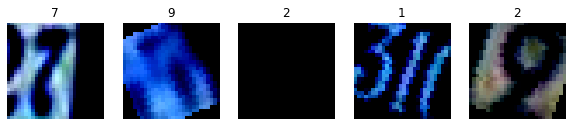

In [3]:
#Image is overally blurry/low resolution - consistent on training set & test set
#If there are some overly clear images, it may influence the model perfomence
#RandomCrop
#RandomRotation
trainT = T.Compose([T.RandomCrop(28)
                   ,T.RandomRotation(degrees = [-30,30])
                   ,T.ToTensor()
                   ,T.Normalize(mean = [0.485,0.456,0.406]
                                ,std = [0.229,0.224,0.225])])
testT = T.Compose([T.CenterCrop(28)
                  ,T.ToTensor()
                  ,T.Normalize(mean = [0.485,0.456,0.406]
                                ,std = [0.229,0.224,0.225])])
train = torchvision.datasets.SVHN(root ='./'
                                 ,split ="train"
                                 ,download = False
                                 ,transform = trainT
                                 )
test = torchvision.datasets.SVHN(root ='./'
                                 ,split ="test"
                                 ,download = False
                                 ,transform = testT
                                )
plotsample(train)

In [4]:
#ResNet18

#Architecture suitable for our datasryt: For example, ResNet18, VGG16, Inception
torch.manual_seed(1412)
resnet18_ = m.resnet18()

resnet18_

class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block1 = nn.Sequential(nn.Conv2d(3,64,kernel_size=3
                                              ,stride=1,padding=1,bias=False)
                                   ,resnet18_.bn1
                                   ,resnet18_.relu) #delete pooling layer
        
        #small dataset,no depth --> increase width
        self.block2 = resnet18_.layer2 #2 residual units
        self.block3 = resnet18_.layer3 #2 residual units
        #average pooling layer+fc linear transformation layer，some as resnet18
        self.avgpool = resnet18_.avgpool
        #Rewrite the linear layer of the output to ensure the correct number of output layears
        self.fc = nn.Linear(in_features=256, out_features=10, bias=True)
    
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],256)
        x = self.fc(x)
        return x

In [5]:
from torchinfo import summary
summary(MyResNet(),(10,3,28,28),depth=2,device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
MyResNet                                 [10, 10]                  --
├─Sequential: 1-1                        [10, 64, 28, 28]          --
│    └─Conv2d: 2-1                       [10, 64, 28, 28]          1,728
│    └─BatchNorm2d: 2-2                  [10, 64, 28, 28]          128
│    └─ReLU: 2-3                         [10, 64, 28, 28]          --
├─Sequential: 1-2                        [10, 128, 14, 14]         --
│    └─BasicBlock: 2-4                   [10, 128, 14, 14]         230,144
│    └─BasicBlock: 2-5                   [10, 128, 14, 14]         295,424
├─Sequential: 1-3                        [10, 256, 7, 7]           --
│    └─BasicBlock: 2-6                   [10, 256, 7, 7]           919,040
│    └─BasicBlock: 2-7                   [10, 256, 7, 7]           1,180,672
├─AdaptiveAvgPool2d: 1-4                 [10, 256, 1, 1]           --
├─Linear: 1-5                            [10, 10]          

In [6]:
#check para
[*MyResNet().block2[0].parameters()][0][0][0] #same para
#tensor([[ 0.0324, -0.0175,  0.0459],
#        [ 0.0728, -0.0392,  0.0903],
#        [-0.0266, -0.0177, -0.0227]], grad_fn=<SelectBackward>)
[*resnet18_.layer2[0].conv1.parameters()][0][0][0]
#tensor([[ 0.0324, -0.0175,  0.0459],
#        [ 0.0728, -0.0392,  0.0903],
#        [-0.0266, -0.0177, -0.0227]], grad_fn=<SelectBackward>)

[*resnet18_.fc.parameters()] # The parameters of the self-designed part are different from instantiated one
[*MyResNet().fc.parameters()]

[Parameter containing:
 tensor([[ 0.0426, -0.0337,  0.0450,  ...,  0.0419,  0.0562,  0.0489],
         [ 0.0001, -0.0439, -0.0366,  ...,  0.0181,  0.0540, -0.0246],
         [-0.0276, -0.0586,  0.0512,  ..., -0.0343, -0.0446, -0.0571],
         ...,
         [-0.0024,  0.0493,  0.0170,  ...,  0.0196, -0.0065, -0.0427],
         [ 0.0143,  0.0131, -0.0224,  ..., -0.0615,  0.0230, -0.0171],
         [ 0.0518,  0.0055,  0.0404,  ...,  0.0225, -0.0290, -0.0249]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0241, -0.0079, -0.0532, -0.0174, -0.0327,  0.0448, -0.0075,  0.0252,
          0.0254,  0.0471], requires_grad=True)]

In [7]:
def IterOnce(net,criterion,opt,x,y):
    """
    function that performs one iteration of the model
    
    net: architecture after instantiation
    criterion: loss function
    opt: algorithms optimazation
    x: all sample in one batch
    y: all true label of the sample in one batch
    """
    sigma = net.forward(x)
    loss = criterion(sigma,y)
    loss.backward()
    opt.step()
    opt.zero_grad(set_to_none=True) #memory efficient gra = none
    yhat = torch.max(sigma,1)[1]
    correct = torch.sum(yhat == y)
    return correct,loss

def TestOnce(net,criterion,x,y):
    """
    function that tests a set of data and outputs the test results
    net: net after  training
    criterion：loss function
    x: all sample in one batch
    y: all true label of the sample in one batch
    """
    #block computational graph tracing
    #saves a lot of memory and speeds up the computation
    with torch.no_grad(): 
        sigma = net.forward(x)
        loss = criterion(sigma,y)
        yhat = torch.max(sigma,1)[1]
        correct = torch.sum(yhat == y)
    return correct,loss

In [8]:
# Early Stopping

class EarlyStopping():
    def __init__(self, patience = 5, tol = 0.0005):
        #The early stop is triggered when the difference between the loss of this iteration and the historical minimum loss
        #is less than a threshold value at successive patience iterations
        
        self.patience = patience
        self.tol = tol #tolerance- cumulative 5 times are below tol to trigger the stop
        self.counter = 0 #counter-counte cumulative counter times
        self.lowest_loss = None
        self.early_stop = False #True - early stopping，False - do not early stopping
    
    def __call__(self,val_loss):
        if self.lowest_loss == None: #first iteration
            self.lowest_loss = val_loss
        elif self.lowest_loss - val_loss > self.tol:
            self.lowest_loss = val_loss
            self.counter = 0
        elif self.lowest_loss - val_loss < self.tol:
            self.counter += 1
            print("\t NOTICE: Early stopping counter {} of {}".format(self.counter,self.patience))
            if self.counter >= self.patience:
                print('\t NOTICE: Early Stopping Actived')
                self.early_stop = True
        return self.early_stop
        #the different between the loss in the iteration and the historical minimum loss - Threshold

In [9]:
def fit_test(net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH):
    """
    Train the model, output acc/loss on the train & test sets after each eopch
    to moniter the model and save the result
    
    para：
    net: net after instantiation
    batchdata：Train data split by Dataloader
    testdata：Test data split by Dataloader
    criterion：loss function
    opt：optimazation agothrithm
    epochs：num of epoches
    tol：early stopping threshold,
    modelname：The name of the model that is now running, used as a filename when saving the weights info
    PATH：path to save the weights info
    
    """
    SamplePerEpoch = batchdata.dataset.__len__() #num of sample in one batch
    allsamples = SamplePerEpoch*epochs
    trainedsamples = 0
    trainlosslist = []
    testlosslist = []
    early_stopping = EarlyStopping(tol=tol)
    highestacc = None
    
    for epoch in range(1,epochs+1):
        net.train()
        correct_train = 0
        loss_train = 0
        for batch_idx, (x, y) in enumerate(batchdata):
            y = y.view(x.shape[0])
            correct, loss = IterOnce(net,criterion,opt,x,y)
            trainedsamples += x.shape[0]
            loss_train += loss
            correct_train += correct
            
            if (batch_idx+1) % 125 == 0:
                #current epoch #
                #n of samples have been trained now
                #n of samples to train in total
                #The percentage of samples trained / the total number of samples to be trained
                print('Epoch{}:[{}/{}({:.0f}%)]'.format(epoch
                                                       ,trainedsamples
                                                       ,allsamples
                                                       ,100*trainedsamples/allsamples))
            
        TrainAccThisEpoch = float(correct_train*100)/SamplePerEpoch
        TrainLossThisEpoch = float(loss_train*100)/SamplePerEpoch #avg - loss on each sample
        trainlosslist.append(TrainLossThisEpoch)
    
        #test the model on the test set after each eopch
        net.eval()
        loss_test = 0
        correct_test = 0
        loss_test = 0
        TestSample = testdata.dataset.__len__()

        for x,y in testdata:
            y = y.view(x.shape[0])
            correct, loss = TestOnce(net,criterion,x,y)
            loss_test += loss
            correct_test += correct

        TestAccThisEpoch = float(correct_test * 100)/TestSample
        TestLossThisEpoch = float(loss_test * 100)/TestSample
        testlosslist.append(TestLossThisEpoch)
        
        #print test & train results after each epochs
        print("\t Train Loss:{:.6f}, Test Loss:{:.6f}, Train Acc:{:.3f}%, Test Acc:{:.3f}%".format(TrainLossThisEpoch
                                                                                                  ,TestLossThisEpoch
                                                                                                  ,TrainAccThisEpoch
                                                                                                  ,TestAccThisEpoch))
        
        #save the weights if the test acc has new highest acc or test loss has new lowest loss
        if highestacc == None: #first test
            highestacc = TestAccThisEpoch
        if highestacc < TestAccThisEpoch:
            highestacc = TestAccThisEpoch
            torch.save(net.state_dict(),os.path.join(PATH,modelname+".pt"))
            print("\t Weight Saved")
        
        #early stopping
        early_stop = early_stopping(TestLossThisEpoch)
        if early_stop == "True":
            break
            
    print("Complete")
    return trainlosslist, testlosslist

def full_procedure(net,epochs,bs,modelname, PATH, lr=0.001,alpha=0.99,gamma=0,wd=0,tol=10**(-5)):
    
    torch.manual_seed(1412)
    
    #Splitting data
    batchdata = DataLoader(train,batch_size=bs,shuffle=True
                       ,drop_last=False,num_workers = 4) #Threads
    testdata = DataLoader(test,batch_size=bs,shuffle=False
                      ,drop_last=False,num_workers = 4)
    
    #loss fuction
    criterion = nn.CrossEntropyLoss(reduction="sum") #Calculation final output when performing loss function calculation
    opt = optim.RMSprop(net.parameters(),lr=lr
                        ,alpha=alpha,momentum=gamma,weight_decay=wd)
    
    #train & test
    trainloss, testloss = fit_test(net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH)
    
    return trainloss, testloss

In [10]:
#def plot function
def plotloss(trainloss, testloss):
    plt.figure(figsize=(10, 7))
    plt.plot(trainloss, color="red", label="Trainloss")
    plt.plot(testloss, color="orange", label="Testloss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
#save model selection result
PATH = "./ModelSelection"

#use default para in the function full_procedure, add timer in the model selection
#save in the current Graphics Memory, batch_size = 256
#MyResNet
avgtime = [] #use to save the model training time
for i in range(6): #6 iteration to test the model stability
    #set randome seede
    #torch.manual_seed(1412)
    
    #Instantiation
    resnet18_ = m.resnet18()
    net = MyResNet().to(device,non_blocking=True)
    
    #train
    start = time() #trainign time
    trainloss, testloss = full_procedure(net,epochs=3, bs=256 
                                         ,modelname="model_seletion_resnet"
                                         ,PATH = PATH)
    avgtime.append(time()-start)

#Delete the network and clear the GPU memory after the loop    
del net
gc.collect()
torch.cuda.empty_cache()
print(np.mean(avgtime))

Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:146.212185, Test Loss:48.499193, Train Acc:49.709%, Test Acc:84.957%
Epoch2:[105257/219771(48%)]
Epoch2:[137257/219771(62%)]
	 Train Loss:46.039781, Test Loss:30.354518, Train Acc:85.675%, Test Acc:90.615%
	 Weight Saved
Epoch3:[178514/219771(81%)]
Epoch3:[210514/219771(96%)]
	 Train Loss:36.291208, Test Loss:29.976130, Train Acc:88.794%, Test Acc:90.880%
	 Weight Saved
Complete
Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:152.243963, Test Loss:43.277826, Train Acc:47.638%, Test Acc:86.812%
Epoch2:[105257/219771(48%)]
Epoch2:[137257/219771(62%)]
	 Train Loss:46.408166, Test Loss:30.063905, Train Acc:85.595%, Test Acc:90.700%
	 Weight Saved
Epoch3:[178514/219771(81%)]
Epoch3:[210514/219771(96%)]
	 Train Loss:36.344349, Test Loss:28.016201, Train Acc:88.873%, Test Acc:91.464%
	 Weight Saved
Complete
Epoch1:[32000/219771(15%)]
Epoch1:[64000/219771(29%)]
	 Train Loss:152.243963, Test Loss:43.277826, Tr

myResNet_test0
Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:138.898549, Test Loss:37.365528, Train Acc:52.282%, Test Acc:88.699%
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:44.308479, Test Loss:28.837856, Train Acc:86.190%, Test Acc:91.395%
	 Weight Saved
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:35.348482, Test Loss:23.151568, Train Acc:89.204%, Test Acc:93.105%
	 Weight Saved
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:30.943988, Test Loss:21.092297, Train Acc:90.675%, Test Acc:93.919%
	 Weight Saved
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:28.698954, Test Loss:18.870959, Train Acc:91.332%, Test Acc:94.841%
	 Weight Saved
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:26.897580, Test Loss:19.652832, Train Acc:91.879%, Test Acc:94.537%
	 NOTICE: Early stopping counter 1 of 5
Epoch7:[471542/2197710(21%)]
Epoch7:[503542/2197710(23%)]

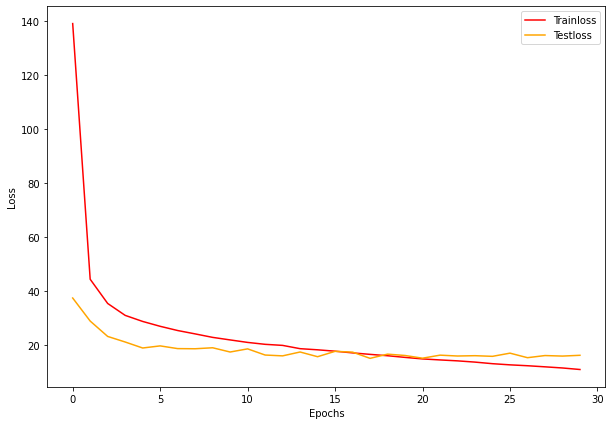

In [11]:
#add to 30 epoches - 
PATH = "./ModelSelection"
modelname = "myResNet_test0"

print(modelname)
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = MyResNet().to(device,non_blocking=True)
start = time() #training time
trainloss, testloss = full_procedure(net,epochs=30, bs=256
                                     ,modelname=modelname
                                     ,PATH = PATH)
print(time()-start)
plotloss(trainloss,testloss)

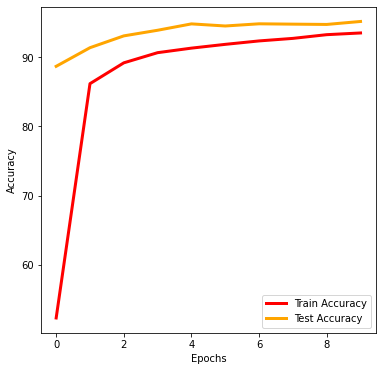

In [25]:
    plt.figure(figsize=(6, 6))
    plt.plot("Train Accuracy", color="red", label="Train Accuracy",data=df,linewidth=3)
    plt.plot("Test Accuracy", color="orange", label="Test Accuracy",data=df,linewidth=3)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

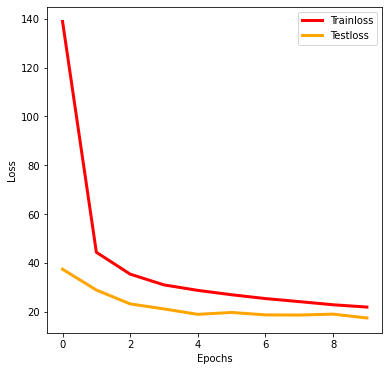

In [26]:
    plt.figure(figsize=(6,6))
    plt.plot(trainloss, color="red", label="Trainloss",linewidth=3)
    plt.plot(testloss, color="orange", label="Testloss",linewidth=3)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()